<h1><center>Natural Language Processing - Twitter Analysis</center></h1>

## Problem Statement

### Context

Twitter's massive user base of 330 million monthly active users presents a direct avenue for businesses to connect with a broad audience. However, the vast amount of information on the platform makes it challenging for brands to swiftly detect negative social mentions that may impact their reputation. To tackle this, sentiment analysis has become a crucial tool in social media marketing, enabling businesses to monitor emotions in conversations, understand customer sentiments, and gain insights to stay ahead in their industry.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

### Objective

The aim of this project is to build a sentimental analysis model that classify the sentiment of tweets into the positive, neutral & negative.

### Data Dictionary

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

## Importing necessary libraries

In [ ]:
pip install contractions


In [ ]:
pip install wordcloud


In [ ]:
#import libraries below
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# download stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# To remove warnings
import warnings
warnings.filterwarnings('ignore')

# To display numbers rounded to 2 decimal places
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)

## Loading the dataset

In [ ]:
# read the data

dataset = pd.read_csv("/content/Tweets.csv")

# copy of the dataset
df = dataset.copy()

## Data Overview

The initial steps to get an overview of any dataset is to:
- Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- Get information about the number of rows and columns in the dataset
- Find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.

In [ ]:
df.head(n=5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.shape

(14640, 15)

There are 14640 rows and 15 columns in the dataset.

In [ ]:
# summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

There are 11 attributes with object datatype, 2 attributes with integer datatype and 2 attributes with float datatype.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

- What is the percentage of tweets for each airline?
- What is the distribution of sentiments across all the tweets?
- What is the distribution of sentiments for each airline?
- What does the plot of negative reasons indicate?
- How does a wordcloud appear for negative tweets?
- How does a wordcloud appear for positive tweets?
- What are insights observed from EDA?

## Data Cleaning

In [ ]:
# converting all columns with dtype object into category to save memory
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [ ]:
# converting tweet_id into a category to save memory
df['tweet_id'] = df['tweet_id'].astype('category')

In [ ]:
# converting tweet_created into a datetime to allow for time series analysis
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df['tweet_created'] = df['tweet_created'].astype('datetime64[ns]')

In [ ]:
# summary of dataset after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  category      
 1   airline_sentiment             14640 non-null  category      
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   category      
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  category      
 6   airline_sentiment_gold        40 non-null     category      
 7   name                          14640 non-null  category      
 8   negativereason_gold           32 non-null     category      
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  category      
 11  tweet_coord                 

## EDA

In [ ]:
# summary of all numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
airline_sentiment_confidence,14640.00,0.90,0.16,0.34,0.69,1.00,1.00,1.00
negativereason_confidence,10522.00,0.64,0.33,0.00,0.36,0.67,1.00,1.00
retweet_count,14640.00,0.08,0.75,0.00,0.00,0.00,0.00,44.00


In [ ]:
# summary of all categorical variables
df.describe(include=['category']).T

,count,unique,top,freq
tweet_id,14640,14485,570281470507352064,2
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_location,9907,3081,"Boston, MA",157


In [ ]:
# summary of datetime variable
df.describe(include=['datetime']).T

,count,unique,top,freq,first,last
tweet_created,14640,14247,2015-02-24 17:54:34,5,2015-02-17 07:36:05,2015-02-24 19:53:37


In [ ]:
# number of tweets by day
by_date = df.groupby(pd.Grouper(key='tweet_created', axis=0, freq='D')).count()['tweet_id']
print(by_date)

tweet_created
2015-02-17     953
2015-02-18    1416
2015-02-19    1298
2015-02-20    1512
2015-02-21    1418
2015-02-22    2392
2015-02-23    3515
2015-02-24    2136
Freq: D, Name: tweet_id, dtype: int64


In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, hue=None, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    hue: whether to groupby another dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column

    ax = sns.countplot(
        data=data,
        x=feature,
        hue=hue,
        palette='viridis',
        order = data[feature].value_counts().index,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotating the percentage

    plt.show()

In [ ]:
# import the figure size for the visualizations
from matplotlib import rcParams

### What is the percentage of tweets for each airline?


In [ ]:
# number of tweets by airline
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

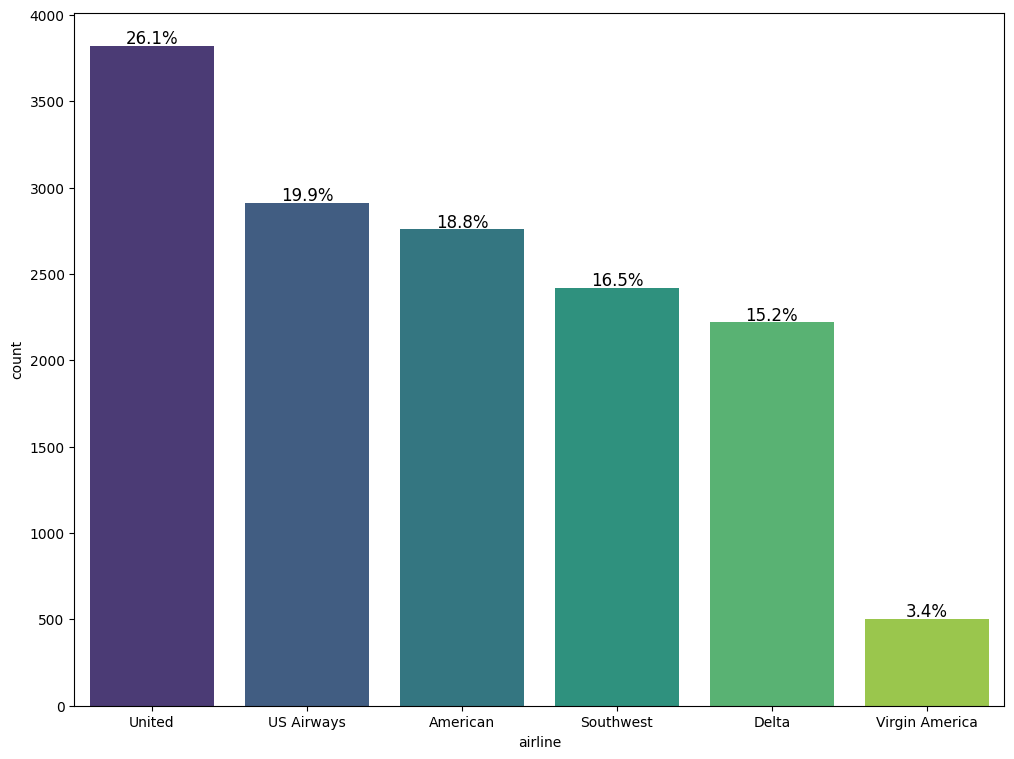

In [ ]:
# labeled barplot of number of tweets by airline
rcParams['figure.figsize'] = 12,9
labeled_barplot(df,'airline',perc=True)

Percentage of the tweets for each airline is as follows: </br>
United            26.1% </br>
US Airways        19.9% </br>
American          18.8% </br>
Southwest         16.5% </br>
Delta             15.2% </br>
Virgin America     3.4%

### What is the distribution of sentiments across all the tweets?


In [ ]:
# number of tweets by sentiment
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

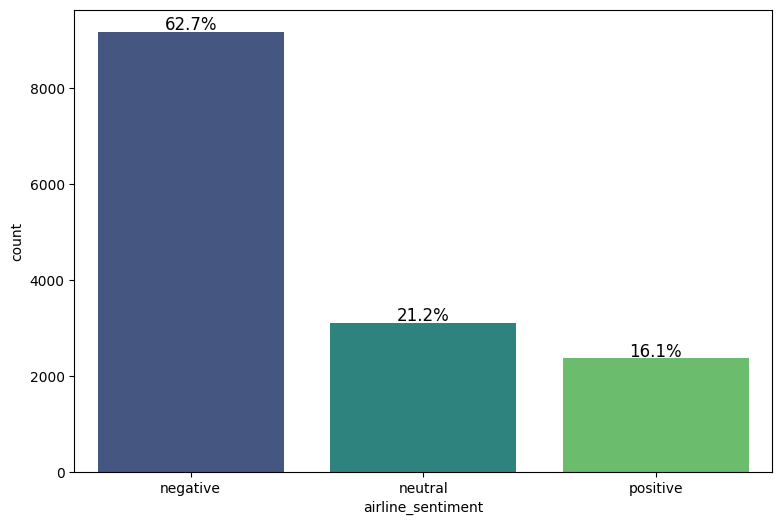

In [ ]:
# labled barplot for number of tweets by sentiment
rcParams['figure.figsize'] = 9,6
labeled_barplot(df,'airline_sentiment',perc=True)

The distribution of sentiments are </br>
- 62.7% Negative </br>
- 21.2% Neutral </br>
- 16.1% Positive

### What is the distribution of sentiments for each airline?


In [ ]:
# number of tweets by sentiment per airline
df.groupby('airline')['airline_sentiment'].value_counts()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment, dtype: int64

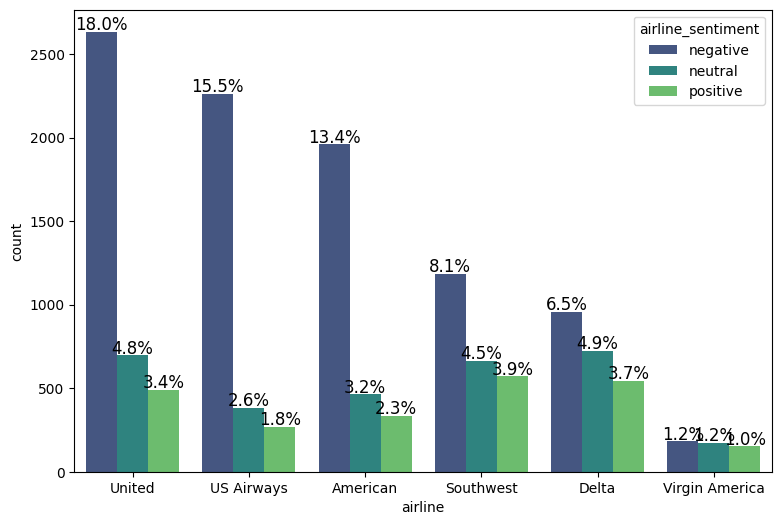

In [ ]:
# labeled barplot for number of tweets by sentiment per airline
labeled_barplot(df,'airline','airline_sentiment',perc=True)

The distribution of sentiments for each airline can be seen in the plot.

### What does the plot of negative reasons indicate?


In [ ]:
# number of tweets by reason for negative sentiment
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

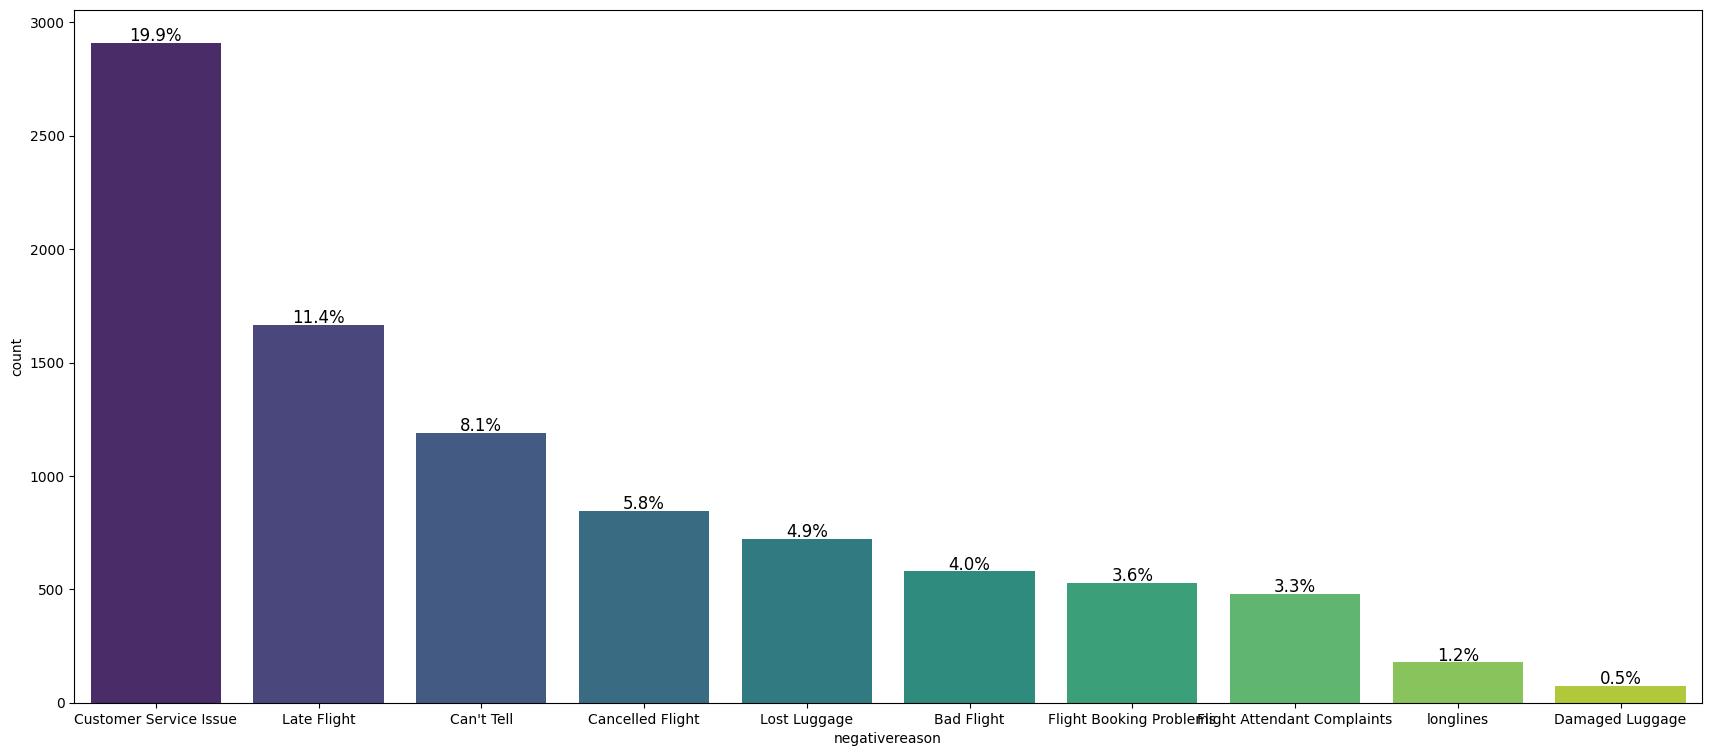

In [ ]:
# labeled barplot for number of tweets per reason for negative sentiment
rcParams['figure.figsize'] = 21,9
labeled_barplot(df,'negativereason',perc=True)

The plot of negative reasons indicate the main reasons for customer dissatisfaction as follows-
* Customer service issue
* Late flight
* Can't tell
* Cancelled flight
* Lost luggage

In [ ]:
from wordcloud import WordCloud

In [ ]:
pip show wordcloud


Name: wordcloud
Version: 1.9.2
Summary: A little word cloud generator
Home-page: https://github.com/amueller/word_cloud
Author: Andreas Mueller
Author-email: t3kcit+wordcloud@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pillow
Required-by: lida


### How does a wordcloud appear for negative tweets?


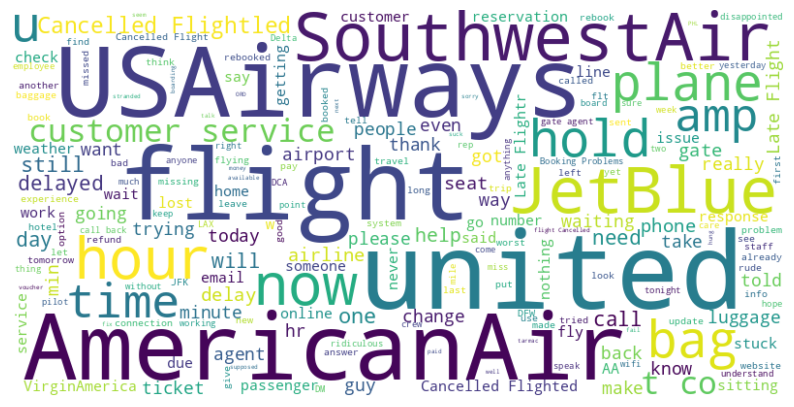

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


neg_tweets = df[df['airline_sentiment'] == 'negative']

# Combine the text of all negative tweets into a single string
neg_tweets_text = ' '.join(neg_tweets['text'])

# Initialize WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(neg_tweets_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Words like Flight, Now, Cancelled, Hour, time, hold, were commonly used in negative tweets

### How does a wordcloud appear for positive tweets?


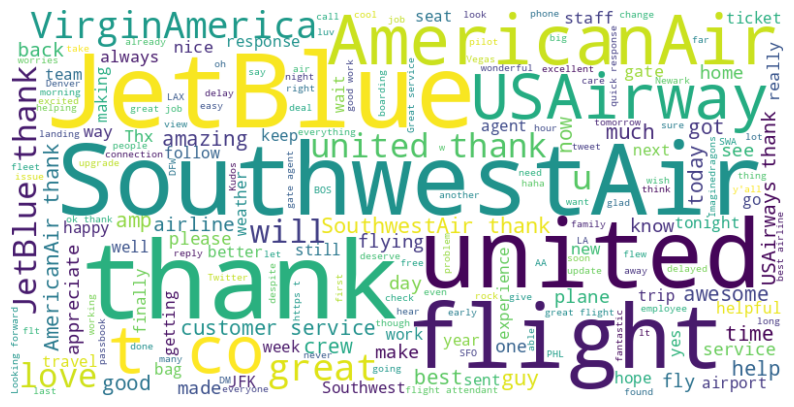

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


pos_tweets = df[df['airline_sentiment'] == 'positive']

# Combine the text of all positive tweets into a single string
pos_tweets_text = ' '.join(pos_tweets['text'])

# Initialize WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(pos_tweets_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Words like thank, flight, love, great, amazing are the commonly used words in the positive tweets.

'Flight' can be noticed as the common word in both positive and negative tweets, indicating that this word will mostly not contribute to a classification model

## Data Preparation for Modeling

- Drop all unnecessary columns
- Remove html tags
- Replace contractions in string(e.g. replace I'm --> I am) and so on.\
- Remove numbers
- Tokenization
- To remove Stopwords
- Lemmatized data

In [ ]:
# datacleaning
column_list = df.columns.to_list()

In [ ]:
# columns used for model building
columns = ['text','airline_sentiment']

In [ ]:
# columns to be dropped
drop_columns = [col for col in column_list if col not in columns]
print(drop_columns)

['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [ ]:
# dropping columns
df_model = df.drop(columns = drop_columns)

In [ ]:
# shape of the dataset
df_model.shape

(14640, 2)

In [ ]:
pd.set_option('display.max_colwidth', None)

df_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [ ]:
#Tokenization
df_model['text'] = df_model.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # tokenization of data
df_model.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, 's, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, amp, ;, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big, bad, thing, about, it]"


In [ ]:
#Normalization
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# removing non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# To convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# To remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# To remove punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# To remove stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# To lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_model['text'] = df_model.apply(lambda row: normalize(row['text']), axis=1)
df_model.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica nt today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face amp little recourse
4,negative,virginamerica really big bad thing


## Model Building

### Using countvectorizer

- Intialize countvectorizer and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from Count vectorizer and random forest model


In [ ]:
# Bag of words
# setting independent variable for classification model
targets = sorted(df_model.airline_sentiment.unique().to_list())
print(targets)

['negative', 'neutral', 'positive']


In [ ]:
# setting the max number of features at 1000
count_vec = CountVectorizer(max_features=1000)
# text to numbers with CountVectorizer
data_features_count = count_vec.fit_transform(df_model['text'])
# data features to array
data_features_count = data_features_count.toarray()

In [ ]:
# shape of the feature vector
data_features_count.shape

(14640, 1000)

In [ ]:
# splitting the data into training and testing set
X_count = data_features_count
y = df_model.airline_sentiment
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.25, shuffle=False, random_state=42)

In [ ]:
# To find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# training the model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_count, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

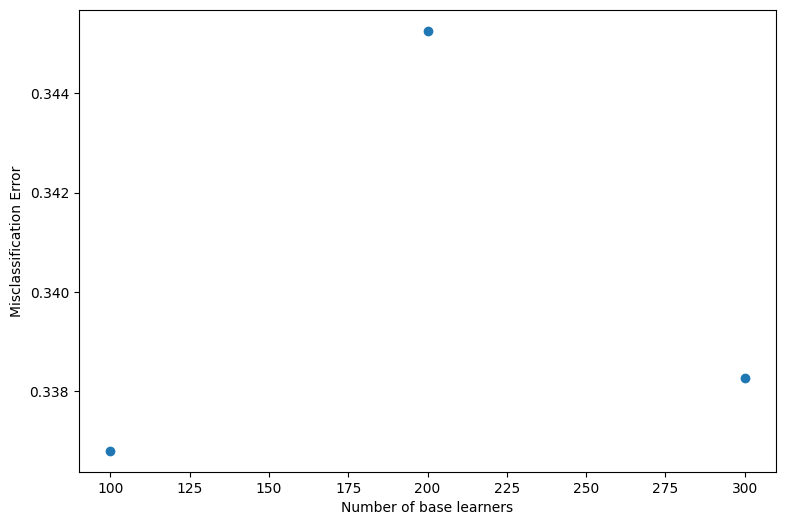

In [ ]:
# figure size
rcParams['figure.figsize'] = 9,6
# To plot the error as k-fold increases
error = [1 - x for x in cv_scores]
optimal_learners = base_ln[error.index(min(error))]
plt.scatter(base_ln, error)
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# train the best model
clf_count = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf_count.fit(X_train_count, y_train)
clf_count.score(X_test_count, y_test)
count_predicted = clf_count.predict(X_test_count)

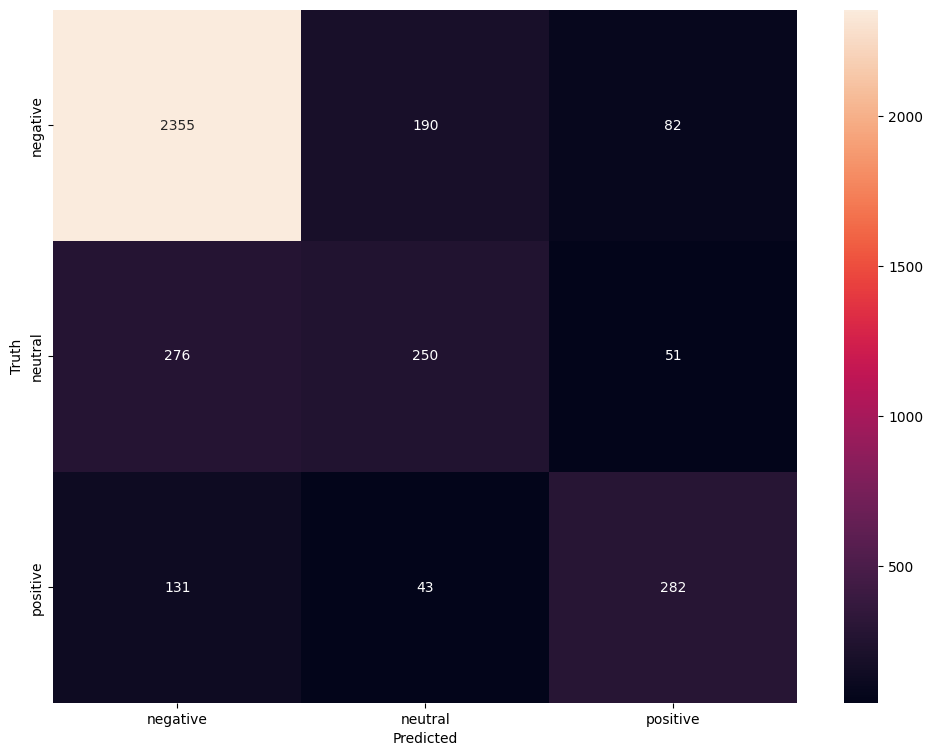

In [ ]:
#To create confusion matrix
from sklearn.metrics import confusion_matrix

cm_count=confusion_matrix(y_test,count_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_count,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

The model built is classifying 2355 out of 2,627 (89.6%) negative tweets correctly, 250 out of 577(43%) neutral tweets correctly, and 282 out of 456 (61.8%) positive tweets correctly

In [ ]:
# top features
all_features_count = count_vec.get_feature_names_out()
top_features_count=''
feat=clf_count.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features_count+=all_features_count[i]
    top_features_count+=', '

top_features_count

'thank, nt, usairways, delay, great, unite, http, jetblue, southwestair, love, awesome, hours, get, hold, cancel, bag, hour, wait, virginamerica, amaze, best, customer, please, time, fly, make, service, help, go, follow, would, plane, need, call, worst, dm, good, airline, flight, lose, '

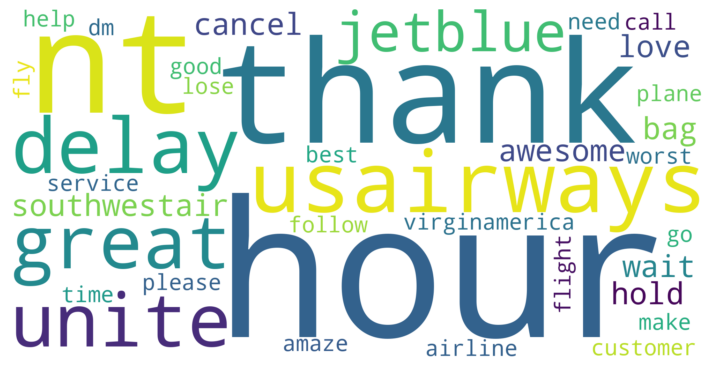

In [ ]:
from wordcloud import WordCloud
# creating word cloud
wordcloud_count = WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features_count)


plt.imshow(wordcloud_count, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [ ]:
# saving variables for model
y_train_count = y_train
y_test_count = y_test

### Using TF-IDF (Term Frequency- Inverse Document Frequency)

- Intialize TFIDF and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from TFIDF and random forest model


In [ ]:
# setting the max number of features at 1000
tfidf_vec = TfidfVectorizer(max_features=1000)
# converting test to numbers with TfidfVectorizer
data_features_idf = tfidf_vec.fit_transform(df_model['text'])
# data features to array
data_features_idf = data_features_idf.toarray()

In [ ]:
data_features_idf.shape

(14640, 1000)

In [ ]:
# splittng data into training and testing set
X_idf = data_features_idf
y = df_model.airline_sentiment
X_train_idf, X_test_idf, y_train, y_test = train_test_split(X_idf, y, test_size=0.25, shuffle=False, random_state=42)

In [ ]:
# To find the optimal number of base learners using k-fold cross-validation
base_ln = np.arange(100,400,100).tolist()

# training the model
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_idf, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

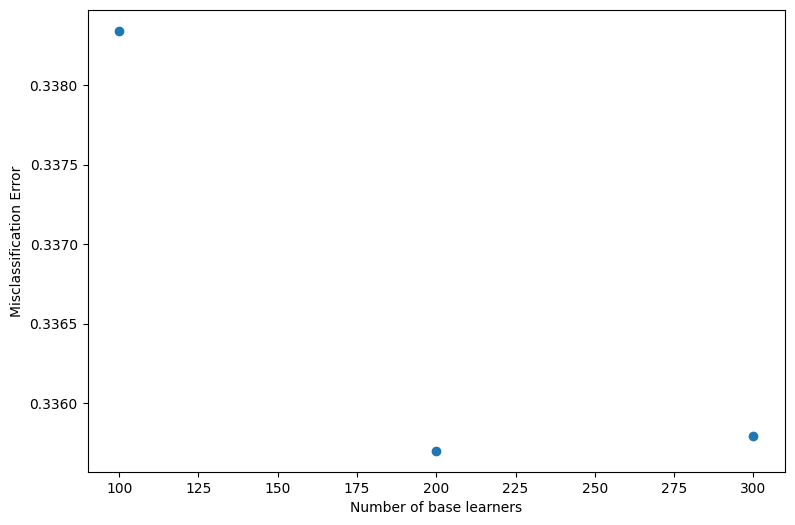

In [ ]:
# plotting the error
error = [1 - x for x in cv_scores]
optimal_learners = base_ln[error.index(min(error))]
plt.scatter(base_ln, error)
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# train the best model
clf = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf.fit(X_train_idf, y_train)
clf.score(X_test_idf, y_test)
tf_idf_predicted = clf.predict(X_test_idf)

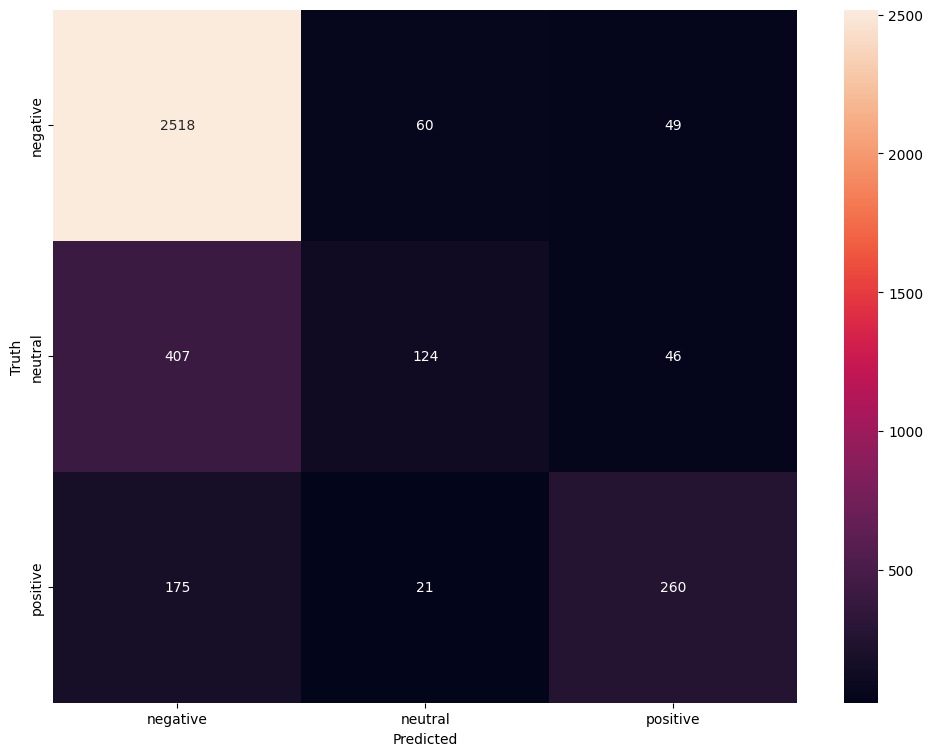

In [ ]:
# create confusion matrix for TF-IDF Vectorizer
cm_tfidf=confusion_matrix(y_test , tf_idf_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_tfidf,annot=True,fmt='d',xticklabels=targets , yticklabels=targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

The model built is classifying 2518 out of 2627 (95.8%)negative tweets correctly, 124 out of 577 (21.5) neutral tweets correctly, and 260 out of 456 (57%) positive tweets correctly

In [ ]:
# top features
all_features = tfidf_vec.get_feature_names_out()
top_features=''
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '

top_features

'thank, jetblue, unite, southwestair, usairways, http, nt, great, delay, virginamerica, love, awesome, get, hold, cancel, hours, bag, wait, best, amaze, fly, please, dm, hour, good, make, follow, time, service, help, flight, need, customer, would, go, fleet, plane, fleek, airline, know, '

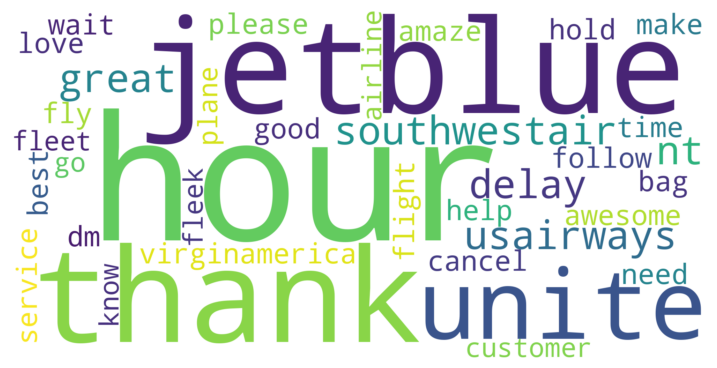

In [ ]:
from wordcloud import WordCloud
# creating the word cloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features)


plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [ ]:
# saving variables for model
y_train_idf = y_train
y_test_idf = y_test

## Recurring Neural Network (RNN)- Sequential model

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder

In [ ]:
text_corpus = df_model.text
labels_corpus = df_model.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(text_corpus, labels_corpus, test_size=0.25, random_state=42)

In [ ]:
# setting hyperparameters
num_words=4000
maxlen=1000

In [ ]:
# To vectorize the text samples
tokenizer = Tokenizer(num_words=num_words, char_level=False)

tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

len(sequences_train)

10980

In [ ]:
# To pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)
print(type(X_train))

Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
<class 'numpy.ndarray'>


In [ ]:
# encoding target variable
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.fit_transform(y_test)

### Defining the model

In [ ]:
from keras import backend
import tensorflow as tf
backend.clear_session()

# setting the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
def create_model(maxlen,num_words,num_categories):

    model = Sequential()

    model.add(Embedding(num_words,output_dim=100,input_length=maxlen,trainable=True))

    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(100)))

    model.add(Dropout(0.2))

    model.add(Dense(128,activation='relu'))

    model.add(BatchNormalization())

    model.add(Dense(64,activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(32,activation='relu'))

    model.add(Dense(num_categories, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
model=create_model(maxlen,num_words,df_model.airline_sentiment.nunique())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         400000    
                                                                 
 batch_normalization (Batch  (None, 1000, 100)         400       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               5

In [ ]:
history = model.fit(X_train, y_train_label, epochs=5, validation_split=0.25)

Epoch 1/5
258/258 [==============================] - 498s 2s/step - loss: 0.7249 - accuracy: 0.7014 - val_loss: 0.9190 - val_accuracy: 0.5020
Epoch 2/5
258/258 [==============================] - 501s 2s/step - loss: 0.5168 - accuracy: 0.7987 - val_loss: 0.6024 - val_accuracy: 0.7439
Epoch 3/5
258/258 [==============================] - 480s 2s/step - loss: 0.3772 - accuracy: 0.8554 - val_loss: 0.6110 - val_accuracy: 0.7577
Epoch 4/5
258/258 [==============================] - 474s 2s/step - loss: 0.2963 - accuracy: 0.8917 - val_loss: 0.7236 - val_accuracy: 0.7537
Epoch 5/5
258/258 [==============================] - 475s 2s/step - loss: 0.2177 - accuracy: 0.9214 - val_loss: 0.9362 - val_accuracy: 0.7596


Model Evaluation

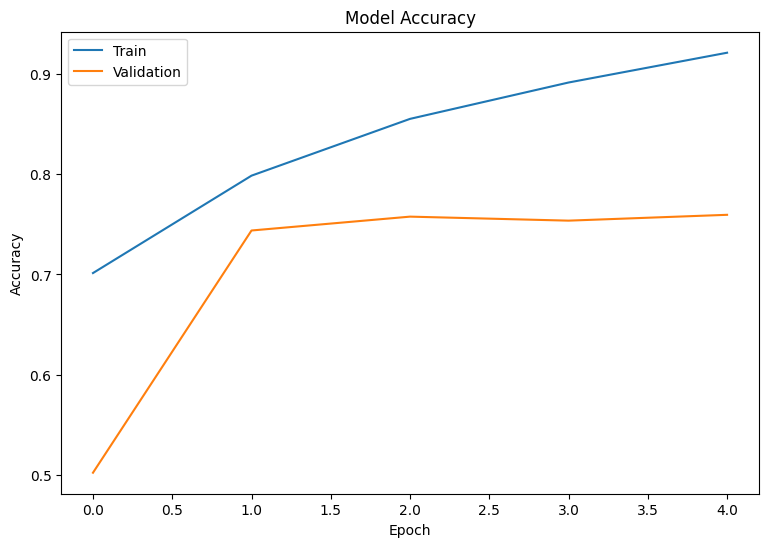

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test, y_test_label, verbose=2)

115/115 - 47s - loss: 0.9078 - accuracy: 0.7544 - 47s/epoch - 408ms/step


In [ ]:
#To create a dictionary to map model predictions to each sentiment
class_dict = {0:'negative',
 1:'neutral',
 2:'positive'}

In [ ]:
#To make predictions on the test data
y_pred_test = model.predict(X_test)

#converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#calculating the probability
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

115/115 [==============================] - 47s 399ms/step


In [ ]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes})

#replacing predictions with sentiments
label_df = df.replace({"Labels":class_dict})

#converting dataframe to array
y_pred_test_classes = label_df.to_numpy()

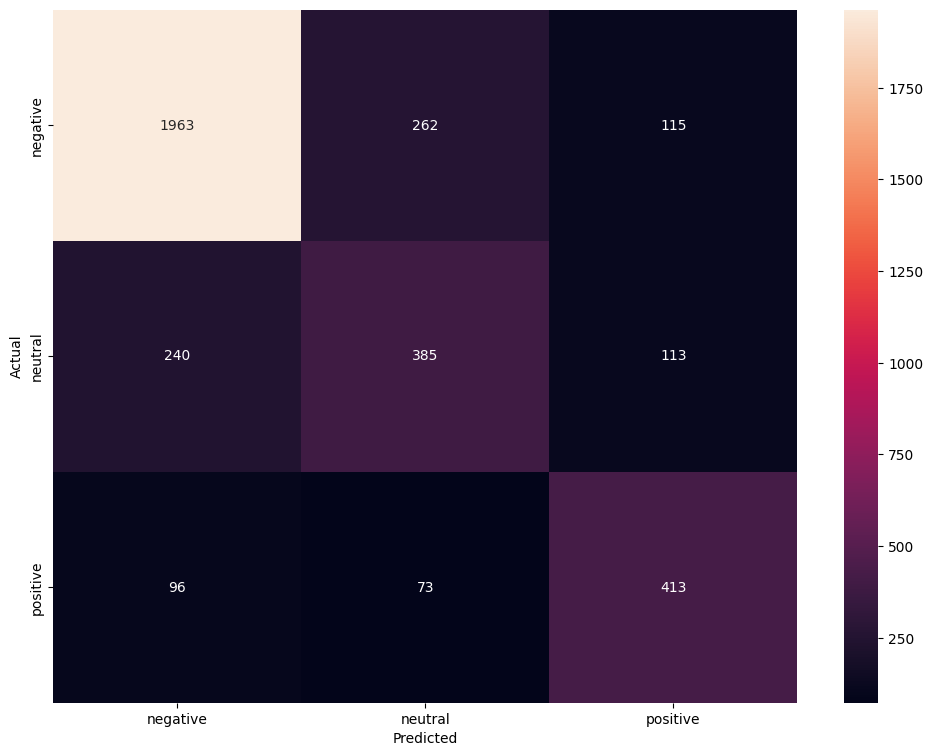

In [ ]:
#To plot the heatmap using confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(12,9))
sns.heatmap(cm_rnn, annot=True,  fmt='.0f', xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The model built is classifying 1,963 out of 2,340 (83.9%) negative tweets correctly, 385 out of 738 neutral (52%) tweets correctly, and 413 out of 582 (71%) positive tweets correctly.

## Summary

---



In [ ]:
# provide a classification report on the Count Vectorizer model
print("Random Forest model trained with Count Vectorizer data")
print(" ")
print(classification_report(y_test_count , count_predicted, target_names = targets))
print(" ")

# provide a classification report on the TF-IDF Vectorizer model
print("Random Forest model trained with TF-IDF Vectorizer data")
print(" ")
print(classification_report(y_test_idf , tf_idf_predicted, target_names = targets))
print(" ")

# provide the classification report on the RNN model
print("Recurring Neural Network (RNN) model")
print(" ")
print(classification_report(y_test, y_pred_test_classes))

Random Forest model trained with Count Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      2627
     neutral       0.52      0.43      0.47       577
    positive       0.68      0.62      0.65       456

    accuracy                           0.79      3660
   macro avg       0.68      0.65      0.66      3660
weighted avg       0.78      0.79      0.78      3660

 
Random Forest model trained with TF-IDF Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.81      0.96      0.88      2627
     neutral       0.60      0.21      0.32       577
    positive       0.73      0.57      0.64       456

    accuracy                           0.79      3660
   macro avg       0.72      0.58      0.61      3660
weighted avg       0.77      0.79      0.76      3660

 
Recurring Neural Network (RNN) model
 
              precision    recall  f1-score   support

    negative       0.85  

Considering the 3 classification models built to analyze the customer sentiments of the given airlines,the results are as follows-</br>
</br>
Random Forest model with Count Vectorizer: </br>
Accuracy: 79% </br>
Precision: 85% (negative), 52% (neutral), 68% (positive) </br>
Recall: 90% (negative), 43% (neutral), 62% (positive)</br>
F1-score: 87% (negative), 47% (neutral), 65% (positive)</br>
</br>
Random Forest model with TF-IDF Vectorizer: </br>
Accuracy: 79%</br>
Precision: 81% (negative), 60% (neutral), 73% (positive)</br>
Recall: 96% (negative), 21% (neutral), 57% (positive)</br>
F1-score: 88% (negative), 32% (neutral), 64% (positive)</br>
</br>
Recurrent Neural Network (RNN) model:</br>
Accuracy: 75%</br>
Precision: 85% (negative), 53% (neutral), 64% (positive)</br>
Recall: 84% (negative), 52% (neutral), 71% (positive)</br>
F1-score: 85% (negative), 53% (neutral), 68% (positive)</br>

**Observations:** </br>
* The Random Forest model with Count Vectorizer still shows competitive performance.
* The Random Forest model with TF-IDF Vectorizer has high precision for the negative class but struggles with recall for the neutral and positive classes.
*The RNN model maintains balanced performance across the three classes but has slightly lower accuracy compared to the Random Forest models.